Library Imports

In [ ]:
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score



2024-12-04 20:18:11.012457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 20:18:11.173876: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 20:18:11.217883: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 20:18:11.515724: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 20:18:14.239319: W tensorflow/compiler/tf2

Load in the data and prep the lables

In [ ]:
data = pd.read_csv("2022-2023_filtered_data.csv")

# Convert datetime column and extract features
data['crash_datetime_y'] = pd.to_datetime(data['crash_datetime_y'])
data['year'] = data['crash_datetime_y'].dt.year
data['month'] = data['crash_datetime_y'].dt.month
data['day'] = data['crash_datetime_y'].dt.day
data['hour'] = data['crash_datetime_y'].dt.hour
data = data.drop(columns=['crash_datetime_y']) 

# Identify and drop zero-variance columns
zero_variance_cols = data.var(axis=0) == 0
data = data.loc[:, ~zero_variance_cols]

# Handle missing values
imputer = SimpleImputer(strategy="mean")
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Scale the feature data (z-normalization)
scaler = RobustScaler()
numeric_columns = ['lat', 'long']  # Targets that are numeric and continuous
categorical_columns = [
    'crash_severity_id_x', 'vehicle_maneuver_id', 'vehicle_contrib_circum_id',
    'extent_deformity_id', 'most_damaged_area_id', 'area_init_impact_id',
    'most_harmful_event_id', 'event_sequence_1_id', 'event_sequence_2_id',
    'event_sequence_3_id', 'event_sequence_4_id', 'crash_severity_id_y',
    'first_harmful_event_id', 'roadway_contrib_circum_id'
]

# Separate latitude and longitude as target variables
lat_long_targets = data[numeric_columns]
X_data = data.drop(columns=numeric_columns)  

# Encode categorical columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X_data[col] = le.fit_transform(X_data[col])
    label_encoders[col] = le

# Scale the remaining features (excluding categorical columns, which are already label-encoded)
X_scaled = scaler.fit_transform(X_data)
X = pd.DataFrame(X_scaled, columns=X_data.columns)

# Scale latitude and longitude targets
lat_long_scaler = RobustScaler()
lat_long_scaled = lat_long_scaler.fit_transform(lat_long_targets)

# Prepare final features and targets
X_data = X  # Features are the scaled dataframe
y_labels = {col: lat_long_scaled[:, i] for i, col in enumerate(['lat', 'long'])}

# Debugging step: Check for missing or infinite values
print("NaNs in features:", X_data.isna().sum().sum())
print("NaNs in targets:", pd.DataFrame(lat_long_scaled).isna().sum().sum())
print("Infinities in features:", np.isinf(X_data).sum().sum())
print("Infinities in targets:", np.isinf(lat_long_scaled).sum().sum())

NaNs in features: 0
NaNs in targets: 0
Infinities in features: 0
Infinities in targets: 0


Split data into training and test data 

In [4]:
# Combine X and y_labels for splitting
combined_data = X.copy()
for key, value in y_labels.items():
    combined_data[key] = value

# Split into training and test data
train_data, test_data = train_test_split(combined_data, test_size=0.3, random_state=42)
X_train = train_data[X.columns]
X_test = test_data[X.columns]
y_train = {key: train_data[key].values for key in y_labels.keys()}
y_test = {key: test_data[key].values for key in y_labels.keys()}

Model for Lat/Lng

Epoch 1/5
4804/4804 ━━━━━━━━━━━━━━━━━━━━ 65s 13ms/step - lat_loss: 7.6522 - lat_mae: 1.6135 - long_loss: 13.4558 - long_mae: 1.9561 - loss: 21.3931 - val_lat_loss: 6.4637 - val_lat_mae: 1.4815 - val_long_loss: 12.4276 - val_long_mae: 1.8156 - val_loss: 19.1420
Epoch 2/5
4804/4804 ━━━━━━━━━━━━━━━━━━━━ 63s 13ms/step - lat_loss: 6.6174 - lat_mae: 1.5538 - long_loss: 13.0058 - long_mae: 1.9049 - loss: 19.8654 - val_lat_loss: 6.7060 - val_lat_mae: 1.4912 - val_long_loss: 12.6847 - val_long_mae: 1.8818 - val_loss: 19.6081
Epoch 3/5
4804/4804 ━━━━━━━━━━━━━━━━━━━━ 63s 13ms/step - lat_loss: 6.6205 - lat_mae: 1.5504 - long_loss: 12.7434 - long_mae: 1.8659 - loss: 19.5750 - val_lat_loss: 6.4697 - val_lat_mae: 1.5130 - val_long_loss: 12.4708 - val_long_mae: 1.8164 - val_loss: 19.1333
Epoch 4/5
4804/4804 ━━━━━━━━━━━━━━━━━━━━ 61s 13ms/step - lat_loss: 6.5939 - lat_mae: 1.5480 - long_loss: 12.6347 - long_mae: 1.8559 - loss: 19.4154 - val_lat_loss: 6.4562 - val_lat_mae: 1.4820 - val_long_loss: 12.3272

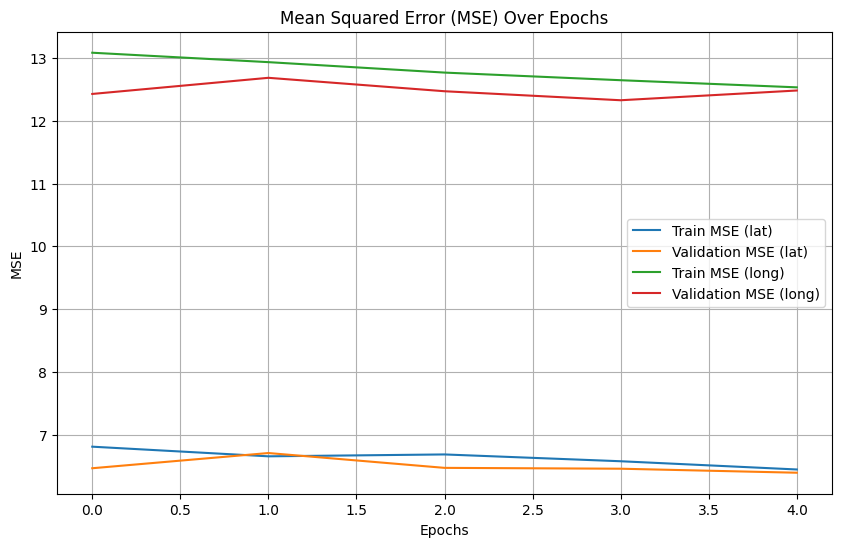

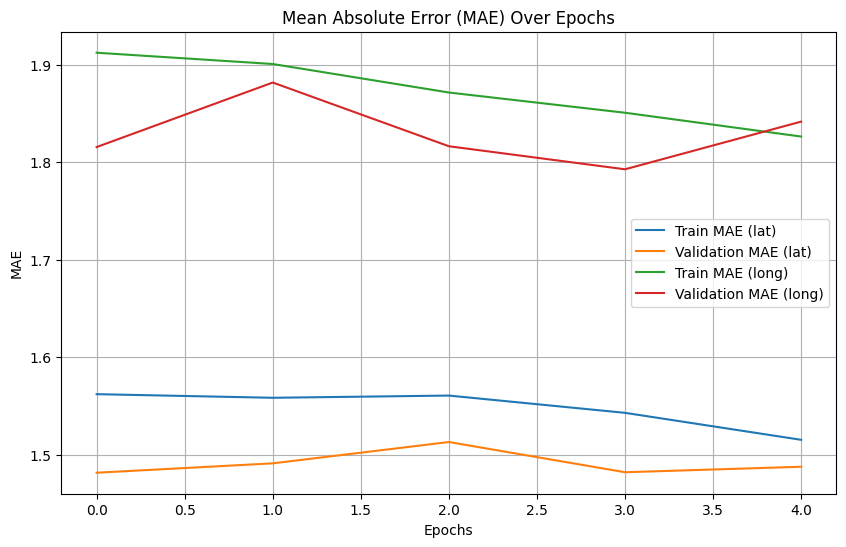

Latitude Metrics:
  Accuracy: 0.7323
  Precision: 0.2011
  F1 Score: 0.0924

Longitude Metrics:
  Accuracy: 0.6681
  Precision: 0.3096
  F1 Score: 0.3036


In [ ]:


# Define the regression model for Latitude and Longitude
inputs = Input(shape=(X.shape[1],))

x = Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal')(inputs)
x = Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal')(x)
lat_output = Dense(1, activation='linear', name='lat')(x)
long_output = Dense(1, activation='linear', name='long')(x)

lat_long_pred_model = Model(inputs=inputs, outputs=[lat_output, long_output])
lat_long_pred_model.compile(
    optimizer=Adam(learning_rate=0.001, clipvalue=1.0),  # Added gradient clipping
    loss={'lat': 'mse', 'long': 'mse'},
    metrics={'lat': 'mae', 'long': 'mae'}
)

# Train the regression model
regression_history = lat_long_pred_model.fit(
    X_train, [y_train['lat'], y_train['long']],
    epochs=5, batch_size=32, validation_data=(X_test, [y_test['lat'], y_test['long']])
)

# Predict latitude and longitude on training and test sets
predicted_lat_long_train = lat_long_pred_model.predict(X_train)
predicted_lat_long_test = lat_long_pred_model.predict(X_test)

X_train_classification = np.column_stack(predicted_lat_long_train)
X_test_classification = np.column_stack(predicted_lat_long_test)

# Plot training and validation loss (MSE)
plt.figure(figsize=(10, 6))
plt.plot(regression_history.history['lat_loss'], label='Train MSE (lat)')
plt.plot(regression_history.history['val_lat_loss'], label='Validation MSE (lat)')
plt.plot(regression_history.history['long_loss'], label='Train MSE (long)')
plt.plot(regression_history.history['val_long_loss'], label='Validation MSE (long)')
plt.title('Mean Squared Error (MSE) Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation MAE
plt.figure(figsize=(10, 6))
plt.plot(regression_history.history['lat_mae'], label='Train MAE (lat)')
plt.plot(regression_history.history['val_lat_mae'], label='Validation MAE (lat)')
plt.plot(regression_history.history['long_mae'], label='Train MAE (long)')
plt.plot(regression_history.history['val_long_mae'], label='Validation MAE (long)')
plt.title('Mean Absolute Error (MAE) Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

# Classification Evaluation
# Define a threshold for binary classification
classification_threshold = 0.5

# Generate binary ground truth labels from the test set
true_lat_class = (y_test['lat'] > classification_threshold).astype(int)
true_long_class = (y_test['long'] > classification_threshold).astype(int)

# Convert regression predictions to binary predictions
predicted_lat_class = (predicted_lat_long_test[0] > classification_threshold).astype(int)
predicted_long_class = (predicted_lat_long_test[1] > classification_threshold).astype(int)

# Calculate metrics for latitude
lat_accuracy = accuracy_score(true_lat_class, predicted_lat_class)
lat_precision = precision_score(true_lat_class, predicted_lat_class, zero_division=0)
lat_f1 = f1_score(true_lat_class, predicted_lat_class, zero_division=0)

# Calculate metrics for longitude
long_accuracy = accuracy_score(true_long_class, predicted_long_class)
long_precision = precision_score(true_long_class, predicted_long_class, zero_division=0)
long_f1 = f1_score(true_long_class, predicted_long_class, zero_division=0)

# Print the metrics
print("Latitude Metrics:")
print(f"  Accuracy: {lat_accuracy:.4f}")
print(f"  Precision: {lat_precision:.4f}")
print(f"  F1 Score: {lat_f1:.4f}")

print("\nLongitude Metrics:")
print(f"  Accuracy: {long_accuracy:.4f}")
print(f"  Precision: {long_precision:.4f}")
print(f"  F1 Score: {long_f1:.4f}")


Train the classification model using predicted lat/long

In [5]:
# Defined classification model
classification_inputs = Input(shape=(2, )) # Two inputs predicted lat/lng

x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal')(classification_inputs)
x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal')(x)

# Create output layers for each categorical label
classification_outputs = {}
for label_name, encoder in data.keys().items(): 
    num_classes = len(encoder.classes_)
    classification_outputs[label_name] = Dense(num_classes, activation='softmax', name=label_name)(x)
    
# Compile classification model
classification_label_model = Model(inputs=classification_inputs, outputs=classification_outputs)
classification_label_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={label: 'sparse_categorical_crossentropy' for label in data.keys()},
    metrics={label: 'accuracy' for label in data.keys()}
)

# Train classification model on the predicted lat/long inputs and categorical labels
classification_label_model_history = classification_label_model.fit(
    X_train_classification, {label: y_train[label] for label in data.keys()},
    epochs=20, batch_size=32, validation_data=(X_test_classification, {label: y_test[label] for label in data.keys()})
)




AttributeError: 'Index' object has no attribute 'items'

In [ ]:

# inputs = Input(shape=(X.shape[1],))


# # Shared layers with reduced L2 regularization
# x = Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal')(inputs)
# x = Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal')(x)
# shared = Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal')(x)

# # Regression branch for lat/long (linear activation)
# reg_branch = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal')(shared)
# lat_output = Dense(1, activation='linear', name='lat')(reg_branch)
# long_output = Dense(1, activation='linear', name='long')(reg_branch)

# # Classification branch for categorical targets
# class_branch = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal')(shared)
# outputs = {'lat': lat_output, 'long': long_output}

# # Add classification outputs for each label
# for label_name in label_encoders.keys():
#     num_classes = len(label_encoders[label_name].classes_)
#     outputs[label_name] = Dense(num_classes, activation='softmax', name=label_name)(class_branch)

# # Compile the model with a lower learning rate and gradient clipping
# model = Model(inputs=inputs, outputs=outputs)
# model.compile(
#     optimizer=Adam(learning_rate=0.0001, clipvalue=1.0),
#     loss={**{'lat': 'mse', 'long': 'mse'}, **{k: 'sparse_categorical_crossentropy' for k in label_encoders.keys()}},
#     metrics={**{'lat': 'mse', 'long': 'mse'}, **{k: 'accuracy' for k in label_encoders.keys()}}
# )


# # Train the model
# history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Use the training data gathered earlier to train the model

In [ ]:
# history = model.fit(
#     X_train,
#     y_train,
#     epochs=20,
#     batch_size=32,
#     validation_data=(X_test, y_test) 
# )

# # Show test results
# test_results = model.evaluate(X_test, {key: y_test[key] for key in y_test})

# # Plot training and validation accuracy
# plt.plot(history.history['crash_severity_id_x_accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_crash_severity_id_x_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Training and Validation Accuracy for Crash Severity ID X')
# plt.show()



Pre processing the routes

In [ ]:
def calculate_bearing(pointA, pointB):
    
    # Calculate the direction from pointA to pointB
    lat1, lng1 = np.radians(pointA)
    lat2, lng2 = np.radians(pointB)
    
    delta_lng = lng2 - lng1 
    x = np.sin(delta_lng) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(delta_lng))
    
    bearing = np.degrees(np.arctan2(x, y)) 
    return (bearing + 360) % 360  # Normalize to 0-360 degrees

def preprocess_route(start_lat, start_lng, end_lat, end_lng, route_points):
    
    #Process the input route into a feature vector for the model
    
    full_route = [(start_lat, start_lng)] + route_points + [(end_lat, end_lng)]
    
    distances = []
    bearings = []
    
    for index in range(len(full_route) - 1):
        pointA = full_route[index]
        pointB = full_route[index + 1]
        
        #Distance between points in miles
        distance = geodesic(pointA, pointB).miles
        distances.append(distance)
        
        # Bearing between points
        bearing = calculate_bearing(pointA, pointB)
        bearings.append(bearing)
        
    # convert lists to numpy arrays
    distances = np.array(distances)
    bearings = np.array(bearings)
    
    features = np.concatenate([distances, bearings])
    # Reshape to 2D array, as required by model input (1 sample, n features)
    return features.reshape(1, -1)
        


Make Predictions

In [ ]:
# Example input from a user for route prediction
start_lat = 34.052235
start_long = -118.243683
end_lat = 40.712776
end_long = -74.005974
route_points = [
    (36.169941, -115.139832),  # Example intermediate point
    (39.739235, -104.990250)   # Another example intermediate point
]

# Process the route to generate features for the regression model
route_features = preprocess_route(start_lat, start_long, end_lat, end_long, route_points)

# Ensure that `route_features` shape matches the expected input shape for the regression model
if route_features.shape[1] != X.shape[1]:
    raise ValueError(f"Feature vector shape {route_features.shape[1]} does not match expected input shape {X.shape[1]}")

# Predict lat and long using the regression model
predicted_lat_long = lat_long_pred_model.predict(route_features)
predicted_lat = predicted_lat_long[0][0]
predicted_long = predicted_lat_long[1][0]

# Combine predicted lat and long as input for the classification model
predicted_lat_long_input = np.array([[predicted_lat, predicted_long]])

# Predict categorical labels using the classification model
classification_predictions = classification_label_model.predict(predicted_lat_long_input)

# Decode and print categorical predictions
decoded_predictions = {}
for label_name, pred in classification_predictions.items():
    decoded_predictions[label_name] = data[label_name].inverse_transform(np.argmax(pred, axis=1))

# Display the final predicted accident location and details
print("Predicted Accident Location:")
print(f"Latitude: {predicted_lat}, Longitude: {predicted_long}")

print("Predicted Accident Details:")
for label_name, decoded_value in decoded_predictions.items():
    print(f"{label_name}: {decoded_value[0]}")
